In [ ]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [1]:
import itertools

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import utils
from tqdm.notebook import tqdm

plt.style.use("ggplot")

# TEOTIL3 Trondheimsfjorden

# Part 9a: Query data via the Vann-Nett API

Using Vann-Nett's `Report` feature, I have manually exported a list of all waterbody names and IDs for Norway (`vannnett_norway_all_waterbodies.xlsx`). 

This notebook filters the list of waterbodies to those around Trondheimsfjorden, and then uses the Vann-Nett API to get WFD status information for as many waterbodies as possible.

## 1. User input

In [2]:
# Vassdragsområder draining to Trondheimsfjorden
vassom_nrs = range(120, 133)

# Water quality elements of interest
quality_element = "ecological"
element_list = ["Total nitrogen", "Total organic carbon", "Total phosphorous"]

# CSV to create
vn_csv = r"../data/vannnett_waterbody_status.csv"

## 2. Get all waterbodies around Trondheimsfjorden

In [3]:
# Read full list of WBs downloaded from Vann-Nett
wb_df = pd.read_excel(
    r"../data/vannnett_norway_all_waterbodies.xlsx", sheet_name="all_wbs"
)
wb_df.drop_duplicates(inplace=True)

# Filter to Trondheimsfjorden
wb_df["vassom"] = wb_df["wb_id"].str.split("-", n=1, expand=True)[0]
vassom_list = [f"{vassom:03d}" for vassom in vassom_nrs]
wb_df = wb_df.query("vassom in @vassom_list")

assert wb_df["wb_id"].is_unique
wb_ids = wb_df["wb_id"].tolist()

print(len(wb_df), "waterbodies around Trondheimsfjorden.")
wb_df.head()

2060 waterbodies around Trondheimsfjorden.


,wb_id,wb_name,vassom
2914,120-108061-L,Hyllmyra,120
2915,120-12-R,Tennelelva,120
2916,120-13-R,Landrøselva- Litjelva i Lensvika,120
2917,120-14-R,Innergårdsbekken-Leirbekken Lensvika,120
2918,120-15-R,Sandabekken Agdenes,120


## 2. Get data from Vann-Nett

In [4]:
# df_list = []
# for wb_id in tqdm(wb_ids):
#     vn_df = utils.get_data_from_vannnett(wb_id, quality_element=quality_element)
#     if vn_df is not None:
#         df_list.append(vn_df)
# vn_df = pd.concat(df_list, axis="rows").reset_index(drop=True)

# vn_df = vn_df.query("parameter in @element_list").reset_index(drop=True)
# wbs_data = vn_df["waterbody_id"].unique().tolist()
# wbs_no_data = set(wb_ids) - set(wbs_data)
# print(len(wbs_data), "waterbodies with at least some data.")
# print(len(wbs_no_data), "waterbodies with no data.")

# vn_df.to_csv(vn_csv, index=False)
# vn_df.head()

In [5]:
# Read saved data for speed
vn_df = pd.read_csv(vn_csv)

# Aggregate results
combos = list(itertools.product(wb_ids, element_list))
combo_df = pd.DataFrame(combos, columns=["waterbody_id", "parameter"])
combo_df = pd.merge(
    combo_df,
    vn_df[["waterbody_id", "parameter", "status"]],
    how="left",
    on=["waterbody_id", "parameter"],
)
combo_df["status"] = combo_df["status"].fillna("Undefined")
combo_df["vassom"] = combo_df["waterbody_id"].str.split("-", n=1, expand=True)[0]
del combo_df["waterbody_id"]
combo_df["count"] = 1
combo_df = combo_df.groupby(["vassom", "parameter", "status"]).count().reset_index()
combo_df.head()

,vassom,parameter,status,count
0,120,Total nitrogen,Good,2
1,120,Total nitrogen,High,12
2,120,Total nitrogen,Moderate,3
3,120,Total nitrogen,Poor,1
4,120,Total nitrogen,Undefined,35


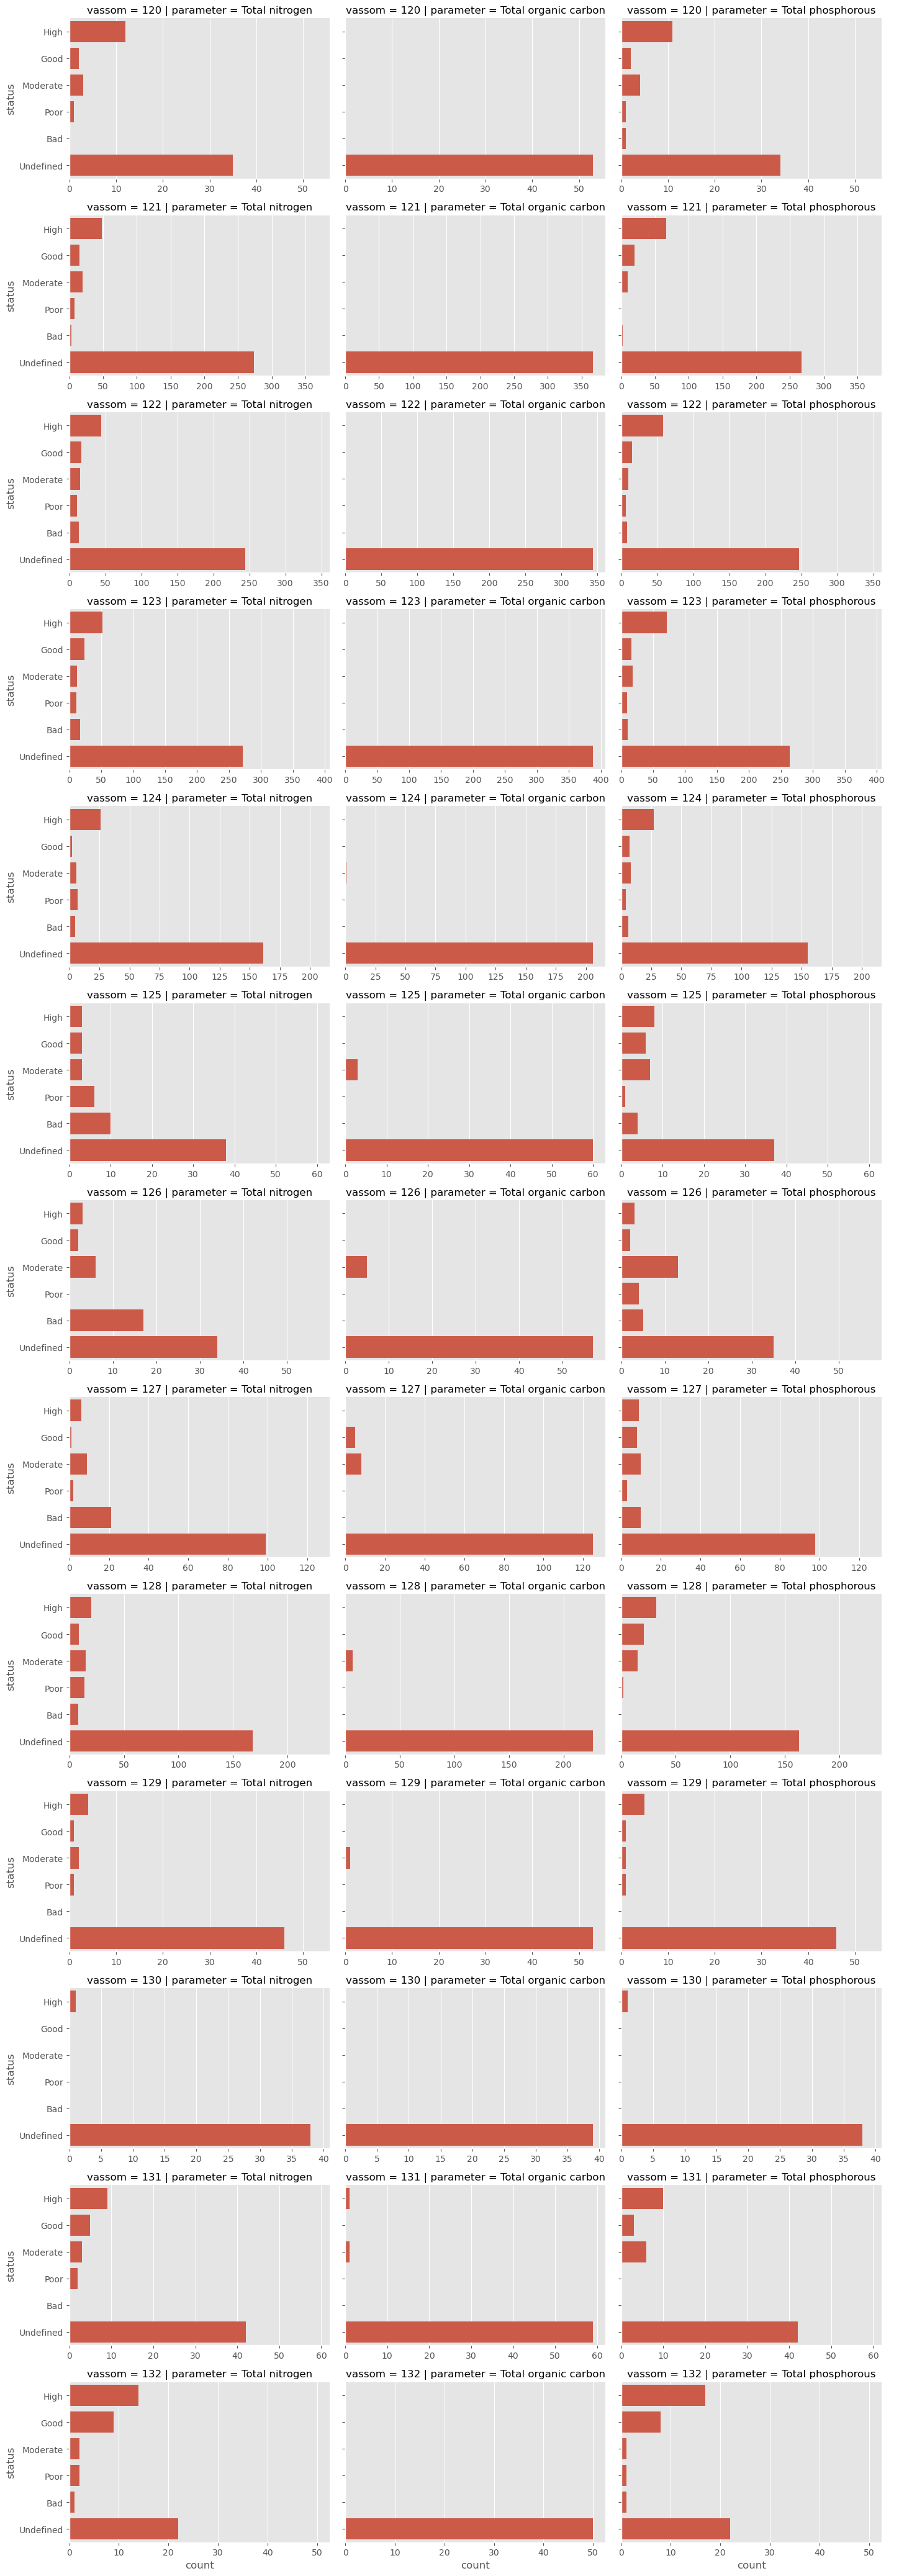

In [6]:
sn.catplot(
    data=combo_df,
    x="count",
    y="status",
    row="vassom",
    col="parameter",
    kind="bar",
    height=3.2,
    aspect=1.5,
    sharex="row",
    order=["High", "Good", "Moderate", "Poor", "Bad", "Undefined"],
)

In [7]:
vn_df.query("waterbody_id == '126-86-R'")

,waterbody_id,category,element,parameter,status,eqr,neqr,value,reference_value,unit,status_limits,year_from,year_to,sample_count,source,data_quality
1142,126-86-R,PhysicoChemical,QE3-1-6-1 - Nitrogen conditions,Total nitrogen,Bad,0.0665,0.0829,4885.578972,325.0,µg/l,550.0;775.0;1325.0;2025.0,2014,2020,131.0,Vannmiljø,Measured
1143,126-86-R,PhysicoChemical,QE3-1-6-1 - Nitrogen conditions,Total organic carbon,Undefined,NaN,NaN,8.781250,NaN,mg/l C,NaN,2015,2020,22.0,Vannmiljø,Measured
1144,126-86-R,PhysicoChemical,QE3-1-6-2 - Phosphorus Conditions,Total phosphorous,Bad,NaN,0.1000,237.070957,NaN,NaN,NaN,2014,2020,131.0,Vannmiljø,Measured
